# NESTML active dendrite tutorial

In this tutorial, we create a neuron model with a "nonlinear" or "active" dendritic compartment, that can, independently from the soma, generate a dendritic action potential. Instead of modeling the membrane potential of the dendritic compartment explicitly, the dendritic action potential (dAP) is modeled here as the injection of a rectangular (pulse shaped) dendritic current into the soma, parameterized by an amplitude and a duration. The rectangular shape can be interpreted as the approximation of an NMDA spike (Antic et al. 2010). A dendritic action potential is triggered when the total synaptic current exceeds a threshold.

The model is an adapted version of the neuron model introduced by Memmesheimer et al. (2012) and Jahnke et al. (2012), and has been used in (Bouhadjar et al., 2022).

**Table of contents**
<ul>
<li>[Adding dAP current to the model](#section_adding_to_model)</li>
<li>[Dynamically controlling synaptic integration](#section_integration)</li></ul>


In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Sep 25 2023 02:58:38

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Adding dAP current to the model
<a id='section_adding_to_model'></a>

We will use a standard, linear integrate-and-fire neuron with the governing equation:
    
\begin{align}
\frac{dV_m}{dt} &= -\frac{1}{\tau_m} (V_m - E_L) + \frac{1}{C_m} (I_{syn} + I_{dAP})
\end{align}

Here, the term $I_{syn}$ contains all the currents flowing into the soma due to synaptic input, and $I_{dAP}$ contains the contribution of a dendritic action potential.

### Implementing the pulse shape

The dAP current is modeled here as a rectangular (pulse) function, parameterized by an amplitude (current strength) and width (duration). 

```nestml
parameters:
    I_dAP_peak pA = 150 pA   # current clamp value for I_dAP during a dendritic action potential
    T_dAP ms = 10 ms         # time window over which the dendritic current clamp is active
    ...
```

We also define a synaptic current threshold that, when crossed, initiates the dendritic action potential:

```nestml
parameters:
    I_th pA = 100 pA         # current threshold for a dendritic action potential
    ...
```

The current is switched on and off as follows. When a dendritic action potential is triggered, the magnitude of the ``I_dAP`` current is set to ``I_dAP_peak``, and a timer variable ``t_dAP`` is set to the duration of the current pulse, ``T_dAP``. At each future run of the NESTML ``update`` block, the timer is decremented until it reaches 0, at which point the dendritic action potential current ``I_dAP`` is set back to zero.
```nestml
update:
    if t_dAP > 0 ms:
        # during a dendritic action potential pulse
        t_dAP -= resolution()
        if t_dAP <= 0 ms:
            # end of dendritic action potential
            I_dAP = 0 pA
            t_dAP = 0 ms

    if I_syn > I_th:
        # current-threshold, emit a dendritic action potential
        t_dAP = T_dAP
        I_dAP = I_dAP_peak
```

The complete neuron model is as follows:

In [2]:
nestml_active_dend_model = '''
model iaf_psc_exp_active_dendrite_neuron:
    state:
        V_m mV = 0 mV     # membrane potential
        t_dAP ms = 0 ms   # dendritic action potential timer
        I_dAP pA = 0 pA   # dendritic action potential current magnitude

    equations:
        # alpha shaped postsynaptic current kernel
        kernel syn_kernel = (e / tau_syn) * t * exp(-t / tau_syn)
        recordable inline I_syn pA = convolve(syn_kernel, spikes_in) * pA
        V_m' = -(V_m - E_L) / tau_m + (I_syn + I_dAP + I_e) / C_m

    parameters:
        C_m pF = 250 pF          # capacity of the membrane
        tau_m ms = 20 ms         # membrane time constant
        tau_syn ms = 10 ms       # time constant of synaptic current
        V_th mV = 25 mV          # action potential threshold
        V_reset mV = 0 mV        # reset voltage
        I_e    pA = 0 pA         # external current
        E_L    mV = 0 mV         # resting potential

        # dendritic action potential
        I_th pA = 100 pA         # current threshold for a dendritic action potential
        I_dAP_peak pA = 150 pA   # current clamp value for I_dAP during a dendritic action potential
        T_dAP ms = 10 ms         # time window over which the dendritic current clamp is active

    input:
        spikes_in <- spike

    output: 
        spike

    update:
        # solve ODEs
        integrate_odes()

        if t_dAP > 0 ms:
            t_dAP -= resolution()
            if t_dAP <= 0 ms:
                # end of dendritic action potential
                t_dAP = 0 ms
                I_dAP = 0 pA

    onCondition(I_syn > I_th):
        # current-threshold, emit a dendritic action potential
        t_dAP = T_dAP
        I_dAP = I_dAP_peak

    onCondition(V_m > V_th):
        # emit somatic action potential
        emit_spike()
        V_m = V_reset
'''

Save to a temporary file and make the model available to instantiate in NEST (see [Running NESTML](https://nestml.readthedocs.io/en/latest/running.html)):

In [3]:
module_name, neuron_name = NESTCodeGeneratorUtils.generate_code_for(nestml_active_dend_model,
                                                                    logging_level="ERROR")  # try "INFO" or "DEBUG" for more debug information

nest.Install(module_name)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Sep 25 2023 02:58:38

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

CMake Warning:
  Ignoring empty string ("") provided on the command line.


CMake Warning (dev) at CMakeLists.txt:93 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The CXX compiler identification is GNU 12.3.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

----------------------------------------

### Running the simulation in NEST

Let's define a function that will instantiate the active dendrite model, run a simulation, and plot and return the results.

In [4]:
def evaluate_neuron(neuron_name, neuron_parms=None, t_sim=100., plot=True):
    """
    Run a simulation in NEST for the specified neuron. Inject a stepwise
    current and plot the membrane potential dynamics and action potentials generated.
    
    Returns the number of postsynaptic action potentials that occurred.
    """
    dt = .1   # [ms]

    nest.ResetKernel()
    try:
        nest.Install("nestml_active_dend_module")
    except :
        pass
    neuron = nest.Create(neuron_name)
    if neuron_parms:
        for k, v in neuron_parms.items():
            nest.SetStatus(neuron, k, v)

    sg = nest.Create("spike_generator", params={"spike_times": [10., 20., 30., 40., 50.]})
    
    multimeter = nest.Create("multimeter")
    record_from_vars = ["V_m", "I_syn", "I_dAP"]
    if "enable_I_syn" in neuron.get().keys():
        record_from_vars += ["enable_I_syn"]
    multimeter.set({"record_from": record_from_vars,
                    "interval": dt})
    sr_pre = nest.Create("spike_recorder")
    sr = nest.Create("spike_recorder")

    nest.Connect(sg, neuron, syn_spec={"weight": 50., "delay": 1.})
    nest.Connect(multimeter, neuron)
    nest.Connect(sg, sr_pre)
    nest.Connect(neuron, sr)
    
    nest.Simulate(t_sim)

    mm = nest.GetStatus(multimeter)[0]
    timevec = mm.get("events")["times"]
    I_syn_ts = mm.get("events")["I_syn"]
    I_dAP_ts = mm.get("events")["I_dAP"]
    ts_somatic_curr = I_syn_ts + I_dAP_ts
    if "enable_I_syn" in mm.get("events").keys():
        enable_I_syn = mm.get("events")["enable_I_syn"]
        ts_somatic_curr = enable_I_syn * I_syn_ts + I_dAP_ts

    ts_pre_sp = nest.GetStatus(sr_pre, keys='events')[0]['times']
    ts_sp = nest.GetStatus(sr, keys='events')[0]['times']
    n_post_spikes = len(ts_sp)
    
    if plot:
        n_subplots = 3
        n_ticks = 4
        if "enable_I_syn" in mm.get("events").keys():
            n_subplots += 1
        fig, ax = plt.subplots(n_subplots, 1, dpi=100)
        ax[0].scatter(ts_pre_sp, np.zeros_like(ts_pre_sp), marker="d", c="orange", alpha=.8, zorder=99)
        ax[0].plot(timevec, I_syn_ts, label=r"I_syn")
        ax[0].set_ylabel("I_syn [pA]")
        ax[0].set_ylim(0, np.round(1.1*np.amax(I_syn_ts)/50)*50)
        ax[0].yaxis.set_major_locator(mpl.ticker.LinearLocator(n_ticks))
        twin_ax = ax[0].twinx()
        twin_ax.plot(timevec, I_dAP_ts, linestyle="--", label=r"I_dAP")
        twin_ax.set_ylabel("I_dAP [pA]")
        twin_ax.set_ylim(0, max(3, np.round(1.1*np.amax(I_dAP_ts)/50)*50))
        twin_ax.legend(loc="upper right")
        twin_ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(n_ticks))
        ax[-2].plot(timevec, ts_somatic_curr, label="total somatic\ncurrent")
        ax[-2].set_ylabel("[pA]")
        if "enable_I_syn" in mm.get("events").keys():
            ax[1].plot(timevec, enable_I_syn, label="enable_I_syn")
            ax[1].set_ylim([-.05, 1.05])
            ax[1].set_yticks([0, 1])
        ax[-1].plot(timevec, mm.get("events")["V_m"], label="V_m")
        ax[-1].scatter(ts_sp, np.zeros_like(ts_sp), marker="d", c="olivedrab", alpha=.8, zorder=99)
        ax[-1].set_ylabel("V_m [mV]")
        ax[-1].set_xlabel("Time [ms]")
        for _ax in set(ax) | set([twin_ax]):
            _ax.grid()
            if not _ax == twin_ax: _ax.legend(loc="upper left")
            if not _ax == ax[-1]: _ax.set_xticklabels([])
            for _loc in ['top', 'right', 'bottom', 'left']: _ax.spines[_loc].set_visible(False) # hide axis outline
        for o in fig.findobj(): o.set_clip_on(False)  # disable clipping
        fig.show()

        return n_post_spikes


Oct 19 03:39:35 NodeManager::prepare_nodes [Info]: 
    Preparing 5 nodes for simulation.

Oct 19 03:39:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5
    Simulation time (ms): 100
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:39:35 SimulationManager::run [Info]: 
    Simulation finished.


/tmp/ipykernel_276055/1944179876.py:84: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


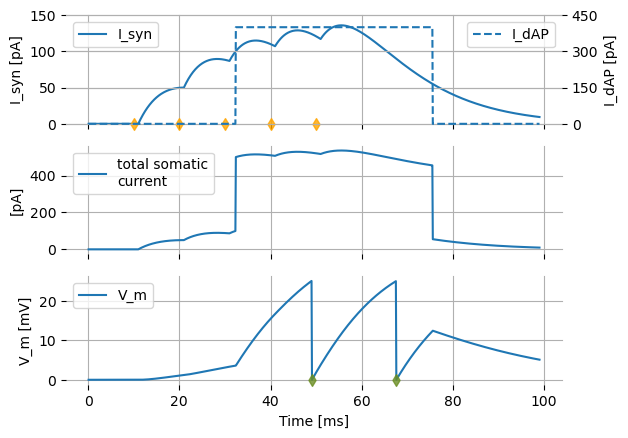

In [5]:
n_post_sp = evaluate_neuron(neuron_name,
                            neuron_parms={"I_th": 100., "I_dAP_peak": 400.})
assert n_post_sp == 2   # check for correctness of the result

In the top panel, we can see the synaptic and dAP currents separately. Incoming action potentials from the presynaptic partner, triggering postsynaptic currents, are indicated by orange diamonds <span style="color:orange; font-size:125%">♦</span>. The middle panel shows the total synaptic current, which is equal to the sum of synaptic and dendritic action potential current. The bottom panel shows the resulting postsynaptic membrane potential, and postsynaptic (somatic) action potentials using green diamonds <span style="color:olivedrab; font-size:125%">♦</span>.

The presynaptic action potentials by themselves are not sufficient by themselves to trigger a postsynaptic action potential, which can be seen by setting the dAP threshold to a very high value, preventing it from triggering. No postsynaptic spikes are observed.


Oct 19 03:39:35 NodeManager::prepare_nodes [Info]: 
    Preparing 5 nodes for simulation.

Oct 19 03:39:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5
    Simulation time (ms): 100
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:39:35 SimulationManager::run [Info]: 
    Simulation finished.


/tmp/ipykernel_276055/1944179876.py:84: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


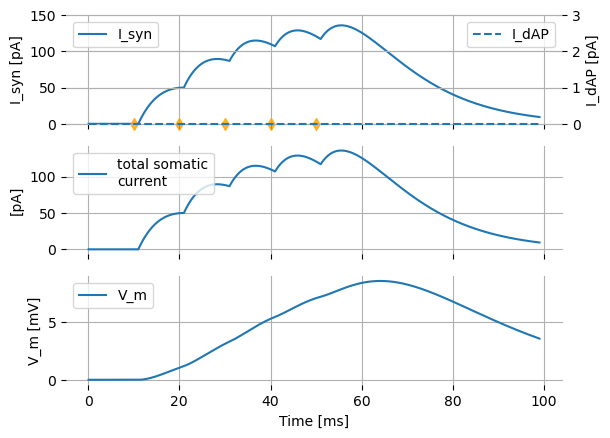

In [6]:
n_post_sp = evaluate_neuron(neuron_name,
                            neuron_parms={"I_th": 9999.})
assert n_post_sp == 0   # check for correctness of the result

## Dynamically controlling synaptic integration
<a id='section_integration'></a>

We now add the additional requirement for the dendritic action potential to disable synaptic integration. When a dendritic action potential happens, we want to ignore synaptic currents for the duration of the action potential, and to reset the synaptic currents such that any presynaptic activity before the dendritic action potential is ignored.

To do this, we add a state variable ``enable_I_syn``, that will have the value 1 if synaptic current integration is enabled, and 0 in case it is disabled. This variables multiplies the ``I_syn`` term in the differential equation for $V_m$. The new governing equation is then:

\begin{align}
\frac{dV_m}{dt} &= -\frac{1}{\tau_m} (V_m - E_L) + \frac{1}{C_m} (\mathtt{enable\_I\_syn} \cdot I_{syn} + I_{dAP})
\end{align}

We can then temporarily disable the synaptic current from contributing to the update of ``V_m`` by setting ``enable_I_syn`` to zero, for instance:

```nestml
update:
    if I_syn > I_th:
        # current-threshold, emit a dendritic action potential
        ...
        # temporarily pause synaptic integration
        enable_I_syn = 0.
        ...
```

In order to ignore presynaptic input that arrives during and before a dendritic action potential, we use the inline aliasing feature of NESTML. Usually, synaptic integration is expressed as a convolution, for example:

```nestml
equations:
    kernel syn_kernel = exp(-t / tau_syn)

    V_m' = -(V_m - E_L) / tau_m + convolve(syn_kernel, in_spikes) / C_m
    ...
```

We will define an inline expression that aliases this convolution (see https://nestml.readthedocs.io/en/latest/nestml_language.html#%28Re%29setting-synaptic-integration-state for a more detailed explanation):

```nestml
equations:
    inline I_syn pA = convolve(syn_kernel, in_spikes)
    ...
```

Now, we can not only use the variable ``I_syn`` in expressions, but we can also assign to it. To reset the state of synaptic integration (thereby "forgetting" any past action potential events):

```nestml
update:
    ...
    if t_dAP <= 0 ms:
        # end of dendritic action potential
        ...
        I_syn = 0 pA
        I_syn' = 0 pA/ms
        ...
```

Putting it all together in a new model, we have:

In [7]:
nestml_active_dend_reset_model = '''
model iaf_psc_exp_active_dendrite_resetting_neuron:
    state:
        V_m mV = 0 mV     # membrane potential
        t_dAP ms = 0 ms   # dendritic action potential timer
        I_dAP pA = 0 pA   # dendritic action potential current magnitude
        enable_I_syn real = 1.   # set to 1 to allow synaptic currents to        # <----
                                 # contribute to V_m integration, 0 otherwise    # <----

    equations:
        # alpha shaped postsynaptic current kernel
        kernel syn_kernel = (e / tau_syn) * t * exp(-t / tau_syn)
        recordable inline I_syn pA = convolve(syn_kernel, spikes_in) * pA
        V_m' = -(V_m - E_L) / tau_m + (enable_I_syn * I_syn + I_dAP + I_e) / C_m

    parameters:
        C_m pF = 250 pF          # capacity of the membrane
        tau_m ms = 20 ms         # membrane time constant
        tau_syn ms = 10 ms       # time constant of synaptic current
        V_th mV = 25 mV          # action potential threshold
        V_reset mV = 0 mV        # reset voltage
        I_e    pA = 0 pA         # external current
        E_L    mV = 0 mV         # resting potential

        # dendritic action potential
        I_th pA = 100 pA         # current-threshold for a dendritic action potential
        I_dAP_peak pA = 150 pA   # current clamp value for I_dAP during a dendritic action potential
        T_dAP ms = 10 ms         # time window over which the dendritic current clamp is active

    input:
        spikes_in <- spike

    output:
        spike

    update:
        # solve ODEs
        integrate_odes()

        if t_dAP > 0 ms:
            t_dAP -= resolution()
            if t_dAP <= 0 ms:
                # end of dendritic action potential
                t_dAP = 0 ms
                I_dAP = 0 pA
                # reset and re-enable synaptic integration
                I_syn = 0 pA                                 # <----
                I_syn' = 0 * s**-1                           # <----
                enable_I_syn = 1.                            # <----

    onCondition(I_syn > I_th):
        # current-threshold, emit a dendritic action potential
        t_dAP = T_dAP
        I_dAP = I_dAP_peak
        # temporarily pause synaptic integration             # <----
        enable_I_syn = 0.                                    # <----

    onCondition(V_m > V_th):
        # emit somatic action potential
        emit_spike()
        V_m = V_reset
'''

Save to a temporary file and make the model available to instantiate in NEST (see [Running NESTML](https://nestml.readthedocs.io/en/latest/running.html)):

In [8]:
module_name, neuron_name = NESTCodeGeneratorUtils.generate_code_for(nestml_active_dend_reset_model,
                                                                    logging_level="ERROR")  # try "INFO" or "DEBUG" for more debug information

nest.Install(module_name)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Sep 25 2023 02:58:38

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

CMake Warning:
  Ignoring empty string ("") provided on the command line.


CMake Warning (dev) at CMakeLists.txt:93 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The CXX compiler identification is GNU 12.3.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

----------------------------------------

If we run the simulation with the same parameters as last time, we now observe only one instead of two action potentials, because the synaptic current (shown as ``I_syn`` in the top subplot below) does not contribute to ``V_m`` during the dendritic action potential interval.


Oct 19 03:39:47 NodeManager::prepare_nodes [Info]: 
    Preparing 5 nodes for simulation.

Oct 19 03:39:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5
    Simulation time (ms): 100
    Number of OpenMP threads: 1
    Not using MPI

Oct 19 03:39:47 SimulationManager::run [Info]: 
    Simulation finished.


/tmp/ipykernel_276055/1944179876.py:84: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


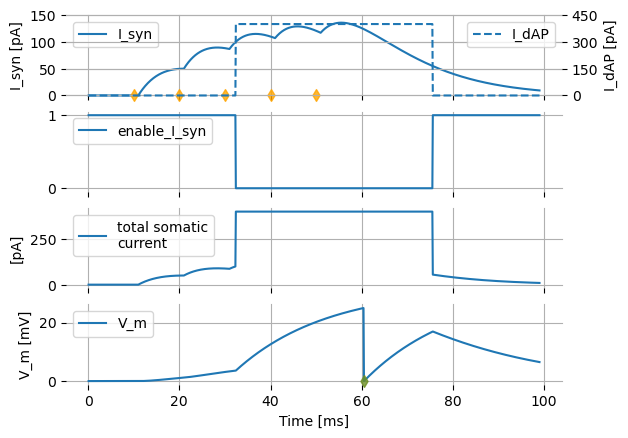

In [9]:
n_post_sp = evaluate_neuron(neuron_name,
                            neuron_parms={"I_th": 100., "I_dAP_peak": 400.})
assert n_post_sp == 1   # check for correctness of the result

## Acknowledgements

We extend our gratitude to Younes Bouhadjar and Tom Tetzlaff for their contributions.

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270 and No. 785907 (Human Brain Project SGA1 and SGA2).


## References

Jahnke, S., Timme, M. & Memmesheimer, R. M. (2012). Guiding synchrony through random networks. Physical Review X, 2(4), 041016. https://doi.org/10.1103/PhysRevX.2.041016

Memmesheimer, R. M. & Timme, M. (2012). Non-additive coupling enables propagation of synchronous spiking activity in purely random networks. PLoS Comput Biol, 8(4), e1002384. https://doi.org/10.1371/journal.pcbi.1002384

Antic, S.D. Zhou, W.-L., Moore, A.R., Short, S.M., & Ikonomu, K.D. (2010). The Decade of the Dendritic NMDA Spike. J Neurosci Res. Nov 1, 88(14). https://doi.org/10.1002/jnr.22444

Bouhadjar, Y., Wouters, D. J., Diesmann, M., & Tetzlaff, T. (2022). Sequence learning, prediction, and replay in networks of spiking neurons. PLoS Computational Biology, 18(6), e1010233.


## Copyright

This file is part of NEST.

Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

NEST is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with NEST.  If not, see <http://www.gnu.org/licenses/>.
